## Modeling

Goal: Predict Pass/Fail of each order

Input:   
1) All data  
2) Germany only data  
3) Ground transit data  

Output:  
1) Feature importance for all data  
2) Feature importance for Germany only  
3) Feature importance for Ground only

In [62]:
# imports
import os
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tools.plotting import autocorrelation_plot
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## Read Data
- normal - all conditions
- germany - only items delivered to germany
- ground - only items delivered via ground

In [135]:
normal = 'data_transformed_sample.csv'
germany = 'germany.csv'
ground = 'ground.csv'

path = os.path.join('..',ground)
df = pd.read_csv(path)

In [136]:
df.shape

(76821, 65)

In [137]:
df.head()

,units_per_order,transit_days,deadline_source,deadline_make,deadline_deliver,source_dur,prod_ready_dur,deliver_dur,planned_diff,total_dur,...,order_day_Thursday,order_day_Tuesday,order_day_Wednesday,deliver_day_Friday,deliver_day_Monday,deliver_day_Saturday,deliver_day_Sunday,deliver_day_Thursday,deliver_day_Tuesday,deliver_day_Wednesday
0,1,2,1612,38,3,62.333333,20.831389,0.958542,0.0,75151,...,0,0,0,0,0,0,0,1,0,0
1,1,3,531,8,3,127.683333,5.011111,0.696481,0.0,85877,...,0,0,0,0,0,0,0,0,1,0
2,1,3,504,8,3,100.300000,4.010833,0.738229,0.0,84240,...,0,0,0,0,0,0,0,0,1,0
3,1,5,492,8,5,88.550000,4.010278,0.738252,0.0,83535,...,0,0,0,0,0,0,0,0,1,0
4,1,1,1544,34,2,221.766667,11.131389,0.205023,0.0,71093,...,0,0,0,0,0,0,0,0,1,0


## Check for infinity and nan values and drop records
Check columns:
- deliver_dur_prop                   
- prod_ready_dur_prop                
- source_dur_prop 

In [138]:
np.isinf(df).sum().sort_values(ascending = False).head() #.sum()

deliver_dur_prop         2
prod_ready_dur_prop      2
source_dur_prop          2
deliver_day_Wednesday    0
country_SWEDEN           0
dtype: int64

In [139]:
#np.isinf(df).sum().sort_values(ascending = False) #.sum()
drop_ind = df[np.isinf(df['deliver_dur_prop'])].index
print (drop_ind)

temp = df[np.isinf(df['prod_ready_dur_prop'])].index
drop_ind.append(temp)
print (temp)

temp = df[np.isinf(df['source_dur_prop'])].index
drop_ind.append(temp)
print (temp)

drop_ind

Int64Index([10897, 21257], dtype='int64')
Int64Index([10897, 21257], dtype='int64')
Int64Index([10897, 21257], dtype='int64')


Int64Index([10897, 21257], dtype='int64')

In [140]:
print (df.shape)
df.drop(drop_ind, inplace=True)
print (df.shape)

(76821, 65)
(76819, 65)


## Prep Data

In [141]:
# only keep the one binary value
y_col = 'delivered_to_plan_FAIL'
remove = 'delivered_to_plan_PASS'

X_cols = df.columns.difference([y_col,remove])

X = df[X_cols]
y = df[y_col]

## CV Models

Test 3 different tree algorithms  
1) Random Forest  
2) Decision Tree  
3) Boosted Tree

In [105]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

In [142]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
scores = cross_val_score(clf, X, y)
scores.mean() 

0.90896783344784471

In [143]:
clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y)
scores.mean()  

0.90253741400458976

In [144]:
clf = GradientBoostingClassifier(n_estimators=100)
scores = cross_val_score(clf, X, y)
scores.mean()

0.90986617684219484

## Run with Boosted model

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

clf = GradientBoostingClassifier(n_estimators=100)
clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [146]:
y_true = y_test
y_pred = clf.predict(X_test)

print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.93      1.00      0.96     13989
          1       0.88      0.22      0.36      1375

avg / total       0.92      0.93      0.91     15364



## Gather ROC Stats by input data

## Normal ROC (all data)

In [108]:
fpr, tpr, threshold = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

In [150]:
roc_auc

0.6075278283989044

## German ROC (only Germany)

In [128]:
fpr_g, tpr_g, threshold_g = roc_curve(y_true, y_pred)
roc_auc_g = auc(fpr_g, tpr_g)

In [149]:
roc_auc_g

0.65912767892517587

## Ground ROC (only Ground transport)

In [147]:
fpr_gr, tpr_gr, threshold_gr = roc_curve(y_true, y_pred)
roc_auc_gr = auc(fpr_gr, tpr_gr)

In [148]:
roc_auc_gr

0.60980729014355439

## Plot ROC for all

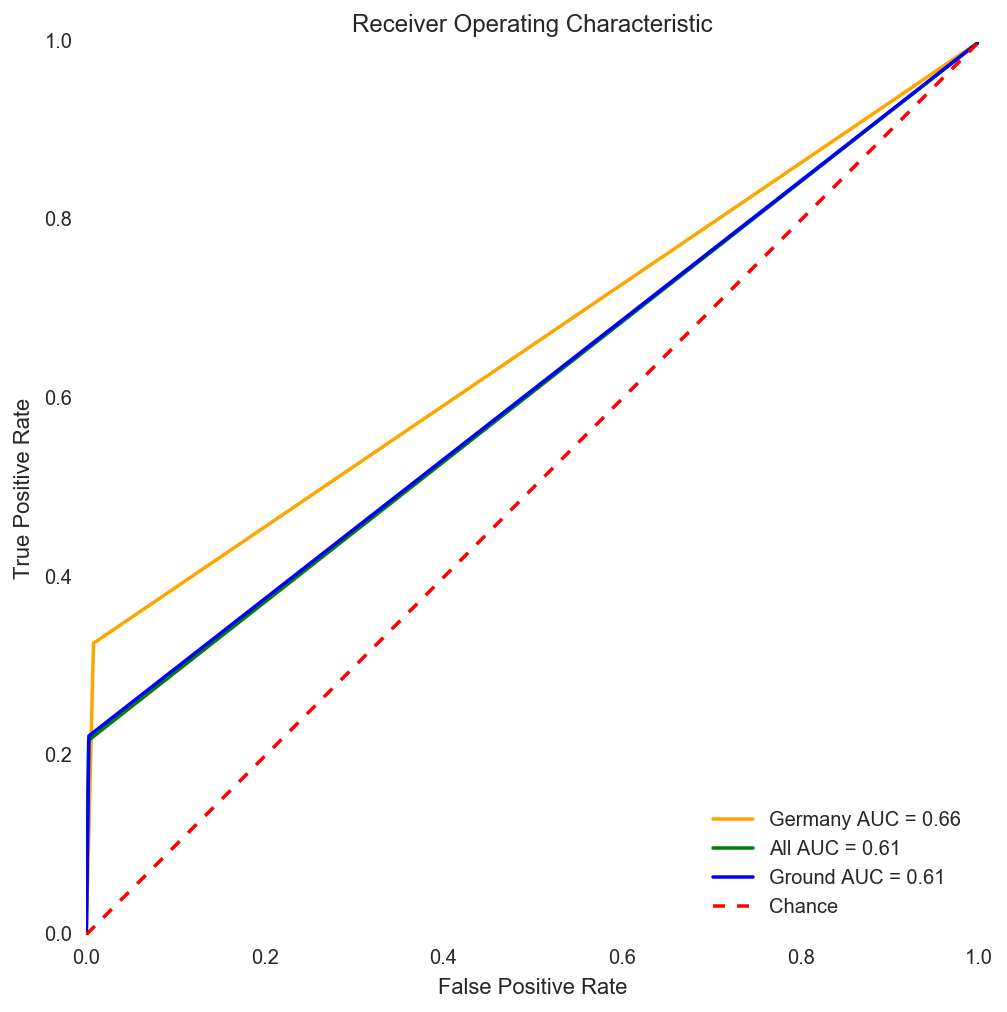

In [162]:
# method I: plt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8,8
plt.rcParams['axes.facecolor']='white'
plt.title('Receiver Operating Characteristic')

# plot 3 different roc curves
plt.plot(fpr_g, tpr_g, 'orange', label = 'Germany AUC = %0.2f' % roc_auc_g)
plt.plot(fpr, tpr, 'green', label = 'All AUC = %0.2f' % roc_auc)
plt.plot(fpr_gr, tpr_gr, 'blue', label = 'Ground AUC = %0.2f' % roc_auc_gr)

plt.plot([0, 1], [0, 1],'r--', label = 'Chance')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.legend(loc = 'lower right')
plt.show()

## Plot Feature Importance

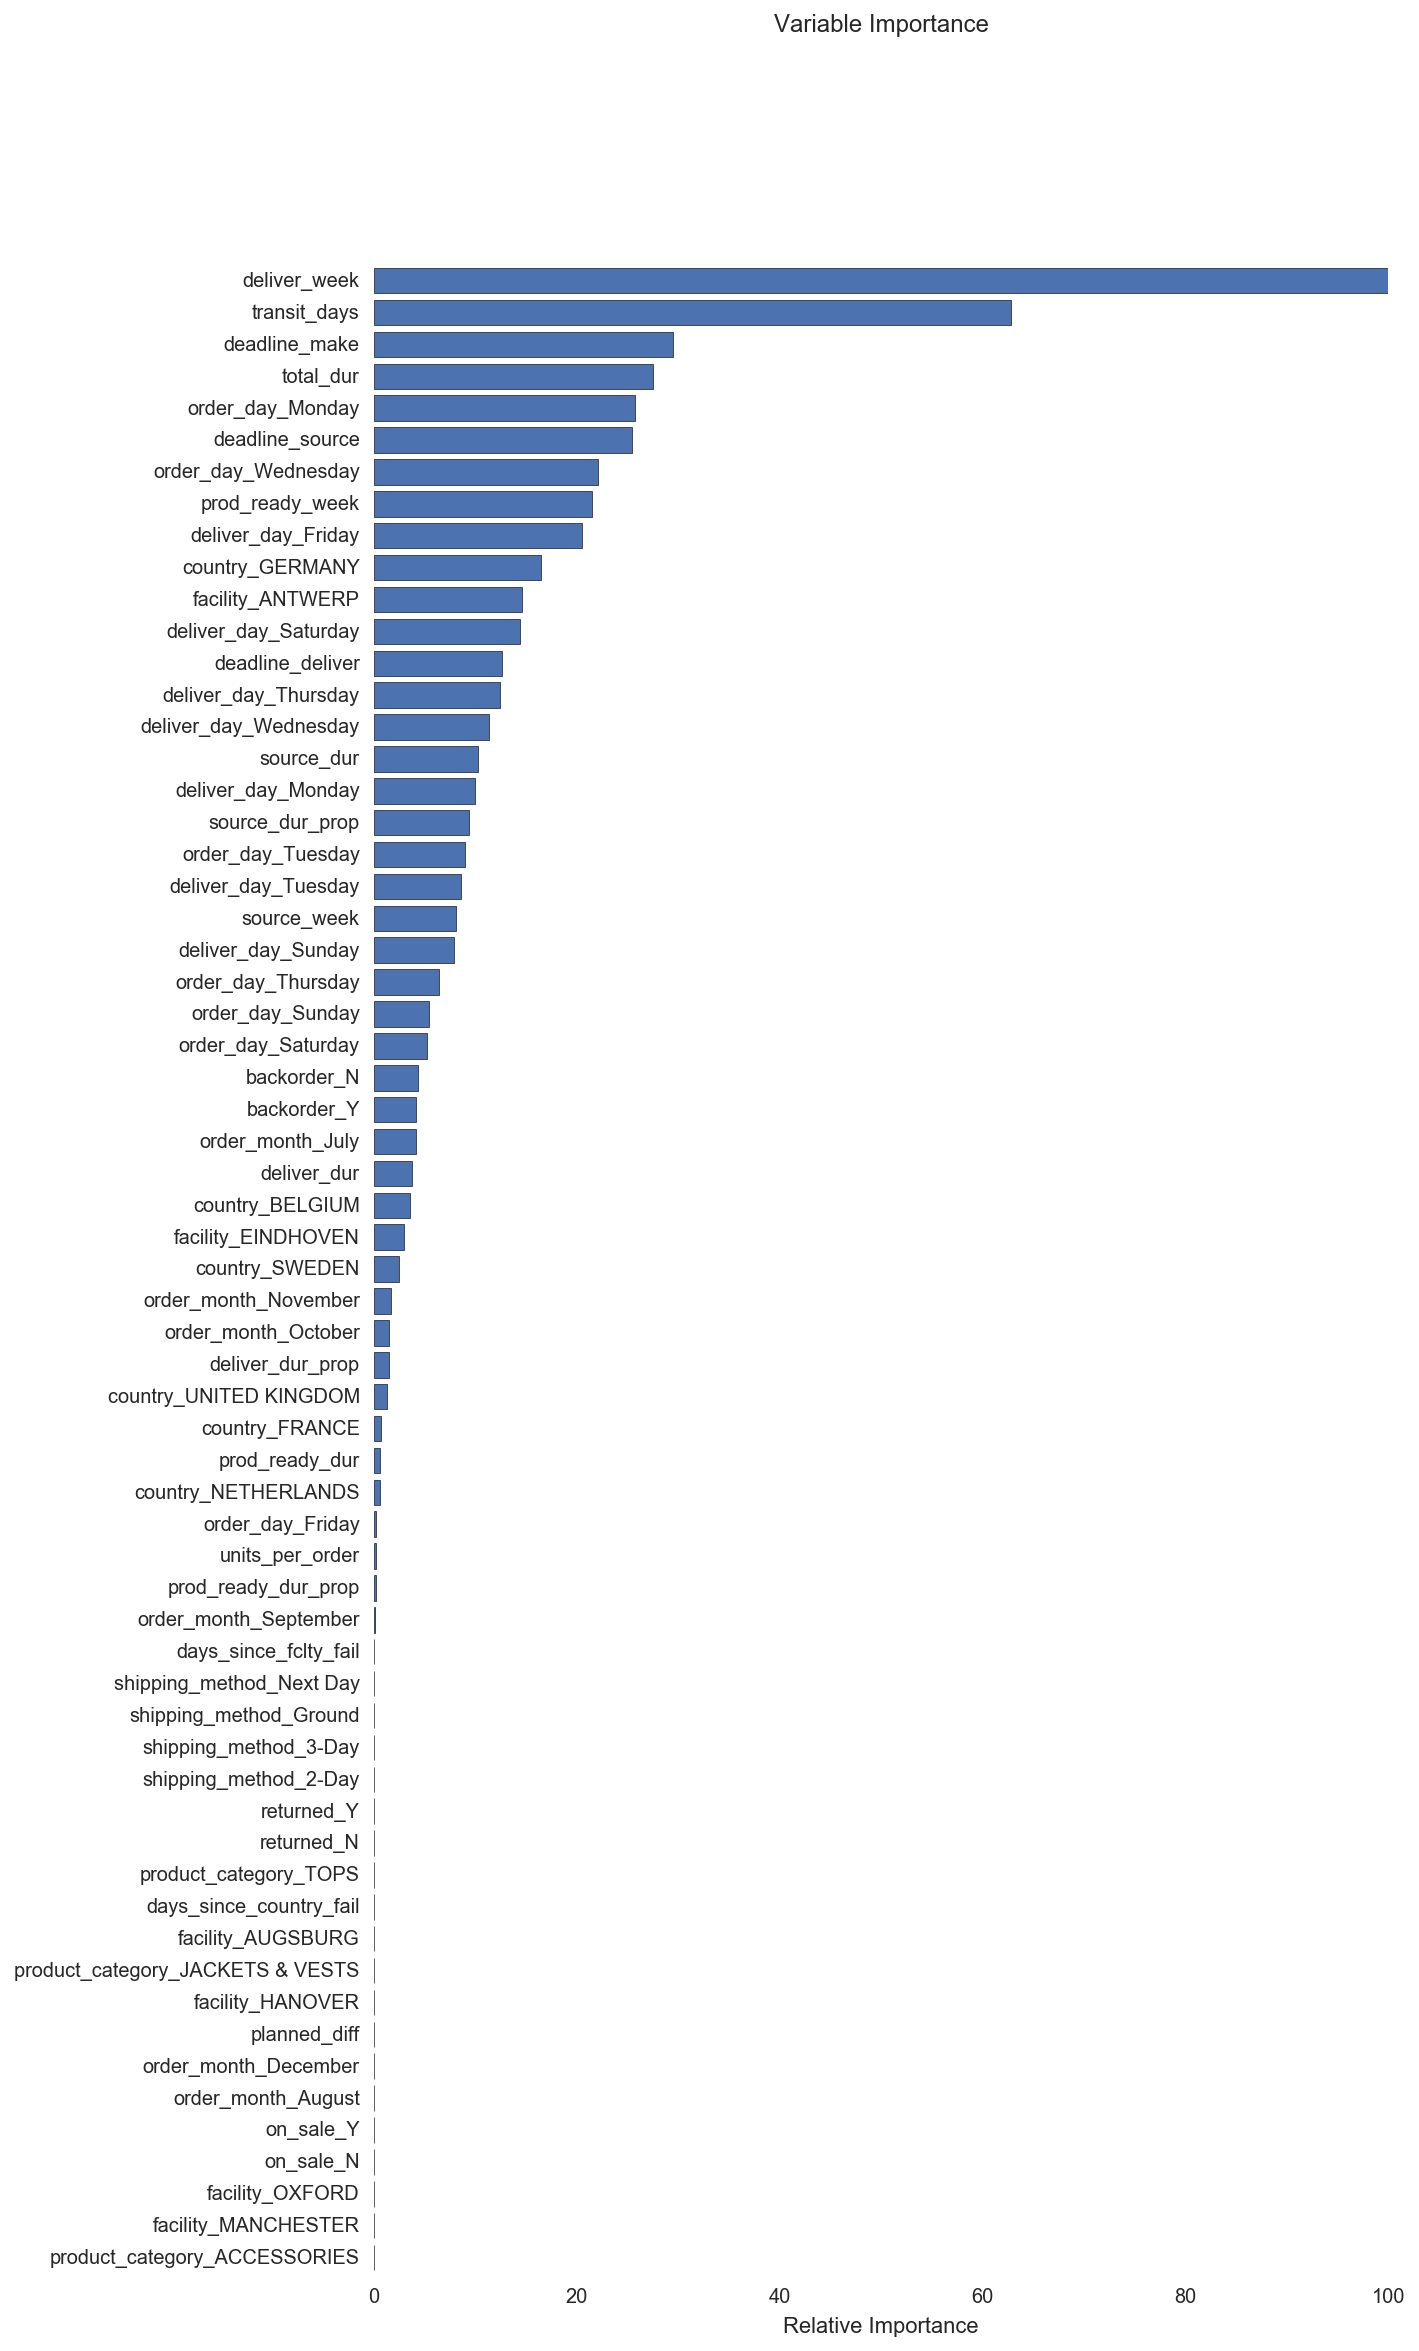

In [156]:
# Plot feature importance
feature_importance = clf.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.rcParams['figure.figsize'] = 20,20
plt.rcParams['axes.facecolor']='white'

plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Save feature importance

In [163]:
# uncomment key based upon which data set is run

#key = 'germany'
key = 'ground'
#key = 'all'

In [158]:
impt = pd.DataFrame(columns=['feature','impt']) #,data=(feature_importance[sorted_idx],X.columns[sorted_idx])

In [159]:
impt['feature'] = X.columns[sorted_idx]
impt['impt'] = feature_importance[sorted_idx]
impt['data'] = key

In [160]:
impt.head()

,feature,impt,data
0,product_category_ACCESSORIES,0.0,ground
1,facility_MANCHESTER,0.0,ground
2,facility_OXFORD,0.0,ground
3,on_sale_N,0.0,ground
4,on_sale_Y,0.0,ground


In [161]:
filename = 'impt_' + key + '.csv'
file = os.path.join('..',filename)
impt.to_csv(file, index=False)